## 0. Purpose
This is a cat and dog classifier program that will classify cats and dogs using a convolutional neural network with Python's tensorflow library. 

## 1. Import Libraries
Import tensorflow and keras V2 for neural network libraries, and tfds to import datasets and matplotlib.pyplot to plot images and graphs. 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
keras = tf.keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


## 2. Import Data
I imported my cat and dog classifier datasets from Kaggle: (https://www.kaggle.com/c/dogs-vs-cats/data).

I loaded it using tfds (https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) which has the same datasets as Kaggle. 

### Functions Usage
I used tfds.load (https://www.tensorflow.org/datasets/api_docs/python/tfds/load) to load the datset. The arguments are name, split, with_into, and as_supervised. It returns a tf.data.Dataset (https://www.tensorflow.org/api_docs/python/tf/data/Dataset), that represents a large set of elements. It allows me to create a dataset, preprocess, and iterate over it.

### Splitting

I split the dataset using tensorflow's splits (https://github.com/tensorflow/datasets/blob/master/docs/splits.md) into a training dataset, a validation dataset, and a testing dataset with a 80%, 10% and 10% split. 

In [ ]:
# splits documentation: https://github.com/tensorflow/datasets/blob/master/docs/splits.md
(raw_train, raw_valid, raw_test), data_info = tfds.load(name = 'cats_vs_dogs',
                                                      split = ['train[:80%]','train[80%:90%]','train[90:]'],
                                                      as_supervised = True,
                                                      with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteUZY38C/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


# 3. Examine and Explore the Data


In [ ]:
#Print the three spliced datassets (tensorflow will only show shapes)
print(raw_train)
print(raw_valid)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
# Get the data info
print(data_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

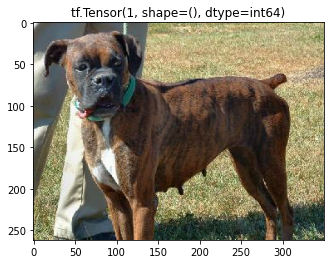

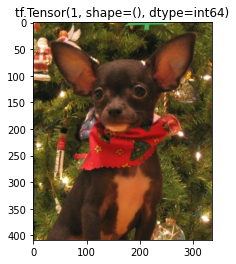

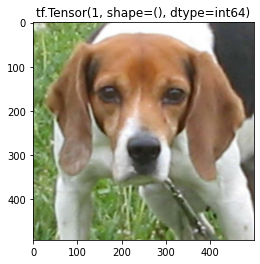

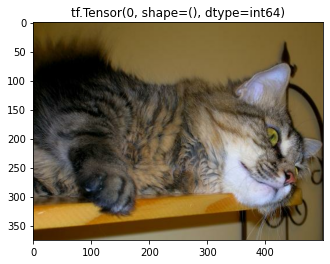

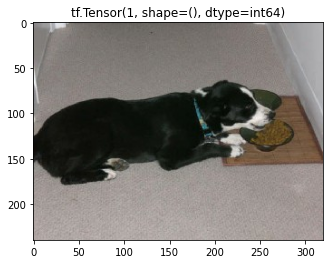

In [ ]:
for image, label in raw_train.take(5): # Enumerate through 5 images
  plt.figure() # Create a figure
  plt.imshow(image) # Show the image as the figure
  plt.title(str(label)) # Label the image

In [ ]:
# Count the number of images in the dataset
size = 0 
for image, label in raw_train:
  size += 1
print(size)

18610


## 4. Preprocess the Data
In order to train the model, we have to prepare the images beforehand.
1. Make them the same input size (resize)
2. Transformations: normalize, convert to float32
3. Shuffle and batch


In [ ]:
# Set the image size to 160 by 160 pixels 
IMG_SIZE = 160

# Function to format the image
def format_img(image, label):
  image = tf.cast(image, tf.float32) # Cast the image to float32 (so tensors can be analyzed)
  image = (image/127.5)-1 # Normalize the image
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # Resize the image
  return image, label # Return the finished image

In [ ]:
# Link the formatted images to new variables
train = raw_train.map(format_img) 
valid = raw_valid.map(format_img)
test = raw_test.map(format_img)

In [ ]:
# Set the batch and shuffle sizes
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000;

In [ ]:
# Shuffle each set of images and batch them based on the batch size
train_batch = train.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
valid_batch = valid.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
test_batch = test.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

In [ ]:
for img, lab in train_batch.take(1):
  print(img.shape)
  print(lab.shape)

(32, 160, 160, 3)
(32,)


# 5. Build the Model
To create the model, I first pretrained the model using MobileNet V2 (https://keras.io/applications/#mobilenetv2). The steps are: 

1. Import the model and tensors
2. Add a global averaging pool
3. Add a classification head (dense)
4. Compile

In [ ]:
# Import the base model and add a global averaging pool and tensors
base_model = keras.applications.MobileNetV2(input_shape = (IMG_SIZE, IMG_SIZE, 3),
                                            include_top = False,
                                            weights='imagenet',
                                            pooling='avg')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Set the base model to trainable
base_model.trainable = False

In [ ]:
# Print the summary of the model
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# Check the tensor shape of the base model
feature_batch = base_model(img)
feature_batch.shape

TensorShape([32, 1280])

In [ ]:
# Add a keras Dense layer classification head (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
prediction_batch.shape

TensorShape([32, 1])

In [ ]:
# Update the new model with keras.Sequential (https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
model = keras.Sequential([
    base_model,
    prediction_layer
])

In [ ]:
lr = 0.0001 # Set the learning rate to 0.0001 (default value)
# Use RMSprop (https://www.tensorfloww.org/api_docs/python/tf/keras/optimizers/RMSprop) to optimize the learning rate based on an adaptive model
optimizer = keras.optimizers.RMSprop(learning_rate = lr)
# Set the loss function using Binary Crossentropy (https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
loss = keras.losses.BinaryCrossentropy(from_logits = True)
# Compile the model given the learning rate and loss (https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
model.compile(optimizer = optimizer,
              loss = loss,
              metrics = ['accuracy']) # Keeps out the accuracy after every epoch

In [ ]:
# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## 6. Train the Model

The steps are: 

1. Set the number of training epochs needed
2. Fit the model based on the training batch
3. Save the model
4. Examine graph using pyplot

In [ ]:
EPOCHS = 10
# Test a simple initial evaluation (https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)
loss0, accuracy0 = model.evaluate(valid_batch, steps = 20)

20/20 [==============================] - 5s 73ms/step - loss: 0.9138 - accuracy: 0.4688


In [ ]:
# Use model.fit (https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) to train the model for 10 epochs
history = model.fit(train_batch, epochs = EPOCHS, validation_data = valid_batch)
model.save('cat_dog_classifier.h5') # Save the model for future use

Epoch 1/10
582/582 [==============================] - 53s 86ms/step - loss: 0.2281 - accuracy: 0.9019 - val_loss: 0.0869 - val_accuracy: 0.9703
Epoch 2/10
582/582 [==============================] - 51s 85ms/step - loss: 0.0728 - accuracy: 0.9742 - val_loss: 0.0636 - val_accuracy: 0.9789
Epoch 3/10
582/582 [==============================] - 51s 85ms/step - loss: 0.0586 - accuracy: 0.9785 - val_loss: 0.0561 - val_accuracy: 0.9802
Epoch 4/10
582/582 [==============================] - 51s 85ms/step - loss: 0.0525 - accuracy: 0.9804 - val_loss: 0.0524 - val_accuracy: 0.9819
Epoch 5/10
582/582 [==============================] - 51s 85ms/step - loss: 0.0490 - accuracy: 0.9818 - val_loss: 0.0501 - val_accuracy: 0.9819
Epoch 6/10
582/582 [==============================] - 51s 85ms/step - loss: 0.0467 - accuracy: 0.9834 - val_loss: 0.0484 - val_accuracy: 0.9832
Epoch 7/10
582/582 [==============================] - 51s 85ms/step - loss: 0.0449 - accuracy: 0.9839 - val_loss: 0.0474 - val_accuracy:

In [ ]:
# Get the loss and the accuracy from the model evaluation
loss, accuracy = model.evaluate(valid_batch, steps = 20)

20/20 [==============================] - 3s 79ms/step - loss: 0.0506 - accuracy: 0.9828


In [ ]:
# Save the model (If already saved, don't run again)
# Mount the drive using Files -> Mount Drive 
model.save('drive/My Drive/Saved_Models/saved_model')

INFO:tensorflow:Assets written to: drive/My Drive/Saved_Models/saved_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/Saved_Models/saved_model/assets


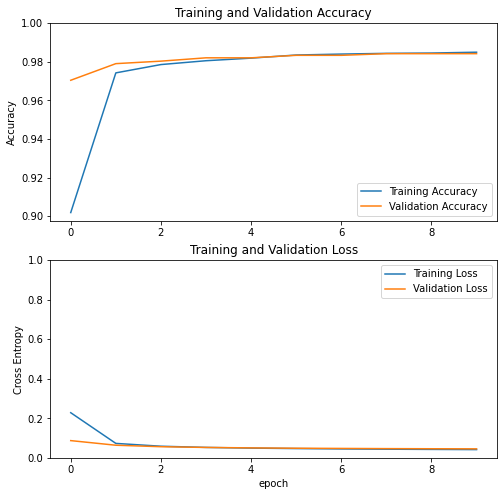

In [ ]:
# Print out the graph using pyplot 

# Get the accuracy and loss of the graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the accuracy graph
plt.figure(figsize = (8, 8)) # Set graph size
plt.subplot(2, 1, 1)
# Set the side labels
plt.plot(acc, label = 'Training Accuracy') 
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right') # Set the legend
# Initialize all other labels
plt.ylabel('Accuracy') 
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Create the loss graph in a similar way
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 7. Test the Model

I now test the model to see if it worked and to analyze its general accuracy using predict_on_batch (https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict_on_batch). 

In [ ]:
# Make sure Drive is mounted
load_model = keras.models.load_model('drive/My Drive/Saved_Models/saved_model')

In [ ]:
# Load the model from Keras
load_model.build((BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3))
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
# Get the loss and accuracy by running a validation batch
loss, accuracy = load_model.evaluate(valid_batch, steps = 20)

20/20 [==============================] - 4s 81ms/step - loss: 0.0422 - accuracy: 0.9859


tf.Tensor([-1.], shape=(1,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


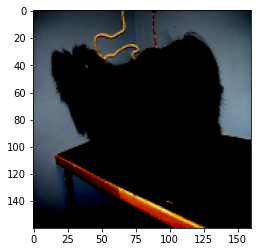

In [ ]:
# Get a images and test the accuracy of the neural network
import random
for img, lab in test_batch.take(1):
  x = random.randint(0, 31)
  print(tf.math.sign(load_model.predict_on_batch(img))[x]) # -1 = cat, 1 = dog
  print(lab[x]) # 0 = cat, 1 = dog
  plt.imshow(img[x])

### Conclusion

Our program is successful, as we have correctly predicted if an image is a cat or a dog with over 98% accuracy on Kaggle datasets using a convolutional neural network. 